In [268]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import ast
import pandas as pd

def convert_invalid_fields(value):
    if not value:
        return None
    return ast.literal_eval(value)  # Convert string to list

# Read the data
flight_name_1 = Path().cwd().parent / "launch_data" / "log_1.csv"
log_buffer_index = 0
data_1 = pd.read_csv(flight_name_1, skiprows=range(1, log_buffer_index), 
                   converters={"invalid_fields": convert_invalid_fields})
flight_name_2 = Path().cwd().parent / "launch_data" / "genesis_launch_2.csv"
data_2 = pd.read_csv(flight_name_2, skiprows=range(1, log_buffer_index), 
                   converters={"invalid_fields": convert_invalid_fields})

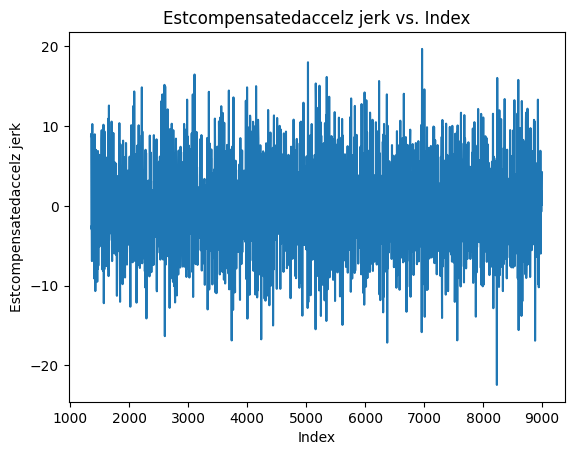

In [269]:
# Calculate and plot the jerk of noise in Standby state, for flight 1:

# Extract the data for the Standby state
field = 'estCompensatedAccelZ'
# Remove empty values:
data = data_1.dropna(subset=[field]).copy()
# Take subset of data after no buzz, and before launch:
data = data.iloc[450:3000]  # 450th packet to 3000th packet
# Calculate the jerk:
data['jerk'] = np.gradient(data[field], 1/500)
# Plot the jerk:
plt.plot(data.index, data['jerk'])
plt.title(f"{field.capitalize()} jerk vs. Index")
plt.xlabel('Index')
plt.ylabel(f"{field.capitalize()} jerk")
plt.show()


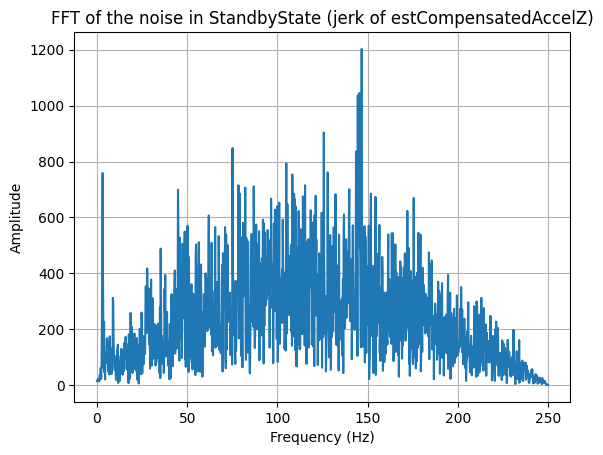

In [270]:
# Find the FFT of the jerk, to see the noise frequency:

# Calculate the FFT of the jerk:
fft = np.fft.fft(data['jerk'])
# Calculate the frequency range:
N = len(data['jerk'])
T = 1/500
fft_noise_abs_nyquist = np.abs(fft)[:N//2]
fft_noise_freq_nyquist = np.fft.fftfreq(N, T)[:N//2]
# Plot the one-sided fft:
plt.plot(fft_noise_freq_nyquist, fft_noise_abs_nyquist)
plt.title(f"FFT of the noise in StandbyState (jerk of {field})")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

[129655.53671765+1.82790114e-11j   8405.25450339-2.74687843e+04j
 -19288.89985763-1.24947309e+04j ... -11186.36025572-1.15625618e+04j
 -19288.89985763+1.24947309e+04j   8405.25450339+2.74687843e+04j]
[-0.00609954 -0.01529239  0.00628739 ...  0.0003635   0.00127574
  0.0003708 ]
0.31704762847381335


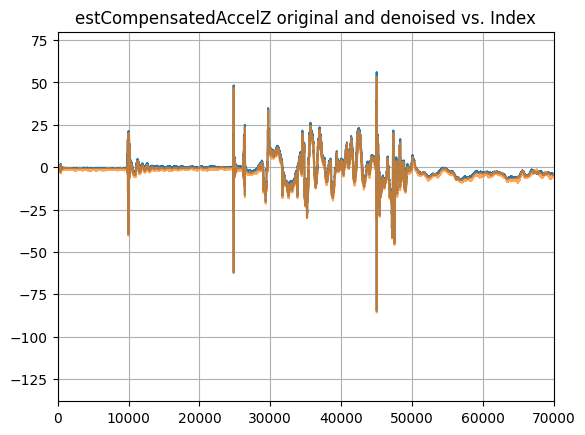

In [ ]:
# Subtract the noise from the data, and plot the result:

stationary_length = len(data[field])
stationary_fft = np.fft.fft(data[field])
stationary_power = stationary_fft ** 2 / stationary_length
# Get all data for the full flight:
data = data_1.dropna(subset=[field]).copy()
flight_fft = np.fft.fft(data[field])
flight_power = np.abs(flight_fft) ** 2 / len(data[field])


# Subtract the noise from the data:
scaling_factor = len(data[field]) / stationary_length
stationary_power = np.interp(
    np.linspace(0, 1, len(flight_power)), 
    np.linspace(0, 1, len(stationary_power)), 
    stationary_power
)
denoised_power = np.maximum(flight_power - stationary_power, 0)  # Avoid negative values
denoised_fft = np.sqrt(denoised_power) * np.exp(1j * np.angle(flight_fft))  #Recalculate the fft
denoised_signal = np.fft.ifft(denoised_fft).real

scaling_factor = np.max(np.abs(data[field])) / np.max(np.abs(denoised_signal))
denoised_signal *= scaling_factor

# Plot the denoised signal and the original signal:
# Only till row 70000:
plt.plot(data.index, data[field], label='Original signal')
plt.plot(data.index, denoised_signal, label='Denoised signal', alpha=0.7)
plt.title(f"{field} original and denoised vs. Index")
plt.xlim(0, 70000)
plt.grid()
plt.show()

# Only add to rows which have "estCompensatedAccelZ" data:
data_1["estCompensatedAccelZ_denoised"] = np.nan
data_1.loc[data_1["estCompensatedAccelZ"].notnull(), "estCompensatedAccelZ_denoised"] = denoised_signal



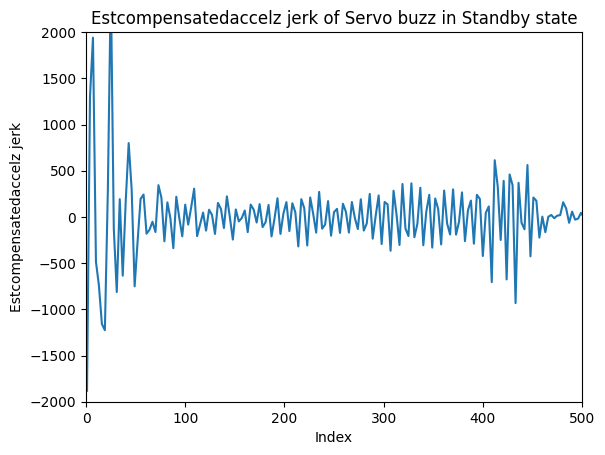

In [310]:
# Calculate and plot the jerk with the index as x-axis, for flight 1

field = 'estCompensatedAccelZ'
data = data_1.dropna(subset=[field]).copy()
# Calculate the jerk:
data['jerk'] = np.gradient(data[field], 1/500)

# Plot the jerk:
plt.plot(data.index, data['jerk'])
# plt.ylim(-750, 750)  # For compensated_accelerationZ jerk
plt.ylim(-2000, 2000)  # For compensated_accelerationY jerk
# print(data['estLinearAccelX'])
# plt.plot(data.index, data[field])
# plt.ylim(9.5, 10.5)  # For vertical_acceleration
# plt.ylim(-10, 10)  # For compensated_accelerationY

plt.xlim(0, 500)
plt.title(f"{field.capitalize()} jerk of Servo buzz in Standby state")
plt.xlabel('Index')
plt.ylabel(f"{field.capitalize()} jerk")
plt.show()

The peaks are at frequencies: [ 96.66666667 161.11111111 163.33333333  81.11111111 157.77777778
  85.55555556 154.44444444  92.22222222  88.88888889 177.77777778]


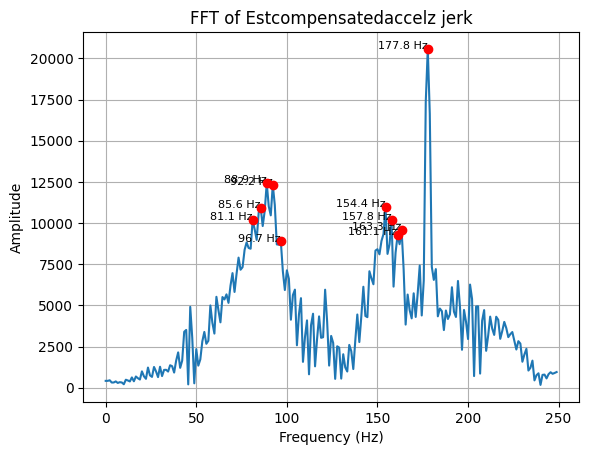

In [311]:
from scipy.signal import find_peaks

# Calculate the fft of the jerk up till row 450:
truncated_jerk = data['jerk'].iloc[:450]

# Calculate the fft:

fft = np.fft.fft(truncated_jerk)
T = 1/500
N = len(truncated_jerk)
fft_abs_nyquist = np.abs(fft)[:N//2]
fft_freq_nyquist = np.fft.fftfreq(N, T)[:N//2]

# Find the highest peaks:
peaks, properties = find_peaks(fft_abs_nyquist, height=0.4*np.max(fft_abs_nyquist))
top_10_peaks = np.argsort(properties['peak_heights'])[-10:]
peaks = peaks[top_10_peaks]
print(f"The peaks are at frequencies: {fft_freq_nyquist[peaks]}")

# Plot the one-sided fft:
plt.plot(fft_freq_nyquist, fft_abs_nyquist)
plt.scatter(
    fft_freq_nyquist[peaks],
    fft_abs_nyquist[peaks],
    color='red',
    label='peaks',
    zorder=5
)

plt.title(f"FFT of {field.capitalize()} {'jerk' if 'jerk' in data.columns else ''}")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()

for peak_idx in peaks:
    # Put text next to the peak and shift it a bit to the right
    freq = fft_freq_nyquist[peak_idx]
    plt.text(freq, fft_abs_nyquist[peak_idx], f"{freq:.1f} Hz", fontsize=8, ha='right')
plt.show()



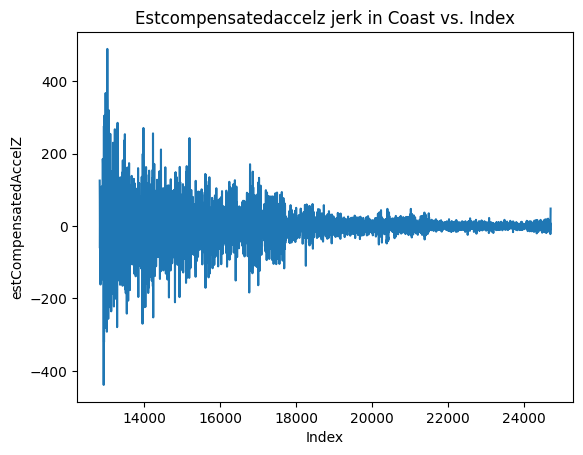

In [312]:
# Let's calculate the jerk for the entire CoastState, for flight 1:
# Get data for the coast state:
coast_state = data[data['state'] == "C"].copy()
# Only include the rows after 0.5 seconds after CoastState, because we want to exclude the 
# retract command in the beginning:
coast_state = coast_state[coast_state['timestamp'] > coast_state['timestamp'].iloc[0] + int(0.5*1e9)]
# Only include the first 500 rows, because I want to check if we can isolate the same frequencies
# as in standby state jerk:
# coast_state = coast_state.iloc[:800]

# Calculate the jerk:
coast_state['jerk'] = np.gradient(coast_state[field], 1/500)

# Plot the jerk:
plt.plot(coast_state.index, coast_state['jerk'])
plt.title(f"{field.capitalize()} {'jerk' if 'jerk' in data.columns else ''} in Coast vs. Index")

plt.xlabel('Index')
plt.ylabel(field)
plt.show()

The peaks are at frequencies: [ 42.2979798  165.65656566 165.02525253 164.77272727 161.11111111
  38.25757576 162.5        159.5959596  107.82828283  39.14141414]


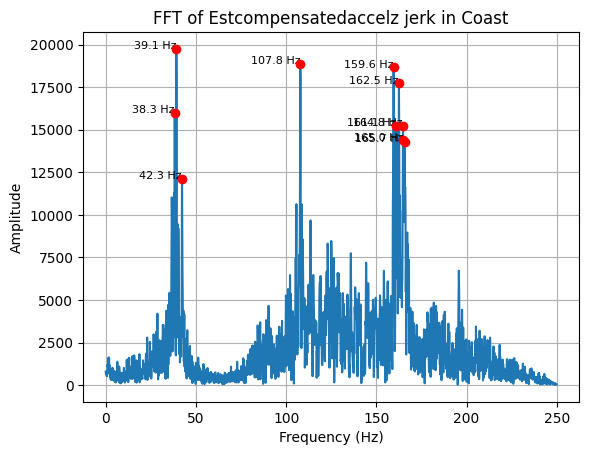

In [313]:
# Now let's do the FFT of the jerk for the coast state:

# Calculate the fft of the jerk:

fft_coast = np.fft.fft(coast_state['jerk'])
T = 1/500
N = len(coast_state['jerk'])
fft_coast_abs_nyquist = np.abs(fft_coast)[:N//2]
fft_freq_coast_nyquist = np.fft.fftfreq(N, T)[:N//2]


coast_peaks, properties = find_peaks(fft_coast_abs_nyquist, height=0.5*np.max(fft_coast_abs_nyquist))
top_10_peaks = np.argsort(properties['peak_heights'])[-10:]
coast_peaks = coast_peaks[top_10_peaks]
print(f"The peaks are at frequencies: {fft_freq_coast_nyquist[coast_peaks]}")

# Plot the one-sided fft:
plt.plot(fft_freq_coast_nyquist, fft_coast_abs_nyquist)

plt.scatter(
    fft_freq_coast_nyquist[coast_peaks],
    fft_coast_abs_nyquist[coast_peaks],
    color='red',
    label='peaks',
    zorder=5
)

plt.title(f"FFT of {field.capitalize()} {'jerk' if 'jerk' in data.columns else ''} in Coast")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()

for peak_idx in coast_peaks:
    # Put text next to the peak and shift it a bit to the right
    freq = fft_freq_coast_nyquist[peak_idx]
    plt.text(freq, fft_coast_abs_nyquist[peak_idx], f"{freq:.1f} Hz", fontsize=8, ha='right')

plt.show()


The intersection of peaks are at frequencies: []


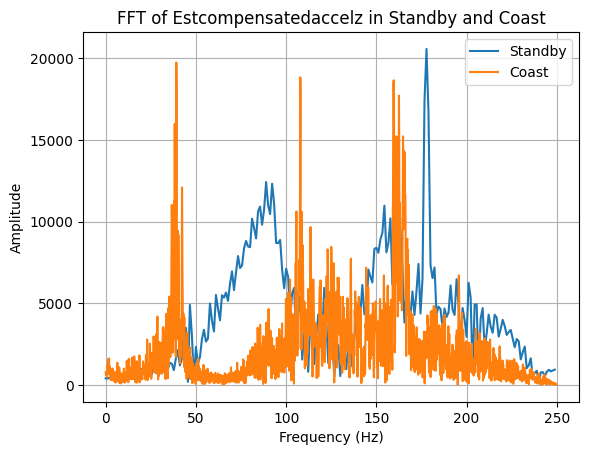

array([ 54.36868687,  -4.54545455,  -1.69191919, -83.66161616,
        -3.33333333,  47.2979798 ,  -8.05555556, -67.37373737,
       -18.93939394, 138.63636364])

In [315]:
# Find the intersection of the peaks in the coast state and the peaks in standby state:

intersection_peaks = np.intersect1d(peaks, coast_peaks)
print(f"The intersection of peaks are at frequencies: {fft_freq_nyquist[intersection_peaks]}")

# Plot both the FFTs together:
plt.plot(fft_freq_nyquist, fft_abs_nyquist, label='Standby')
plt.plot(fft_freq_coast_nyquist, fft_coast_abs_nyquist, label='Coast')

plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.title(f"FFT of {field.capitalize()} in Standby and Coast")
plt.legend()
plt.grid()
plt.show()

# Calculate difference in frequency between the peaks in standby and coast state:

freq_diff = fft_freq_nyquist[peaks] - fft_freq_coast_nyquist[coast_peaks]
freq_diff

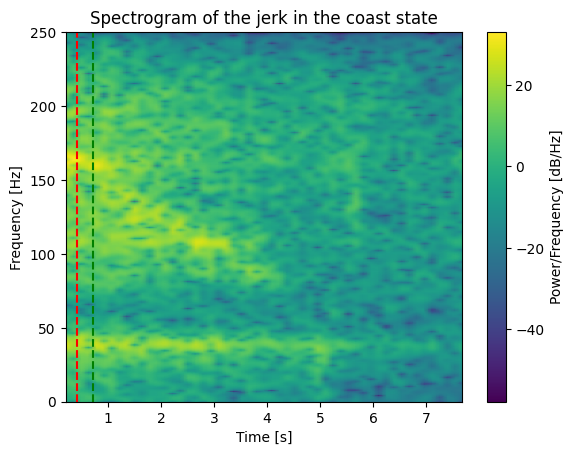

In [330]:
from scipy.signal import spectrogram

# Perform a time-frequency analysis of the jerk in the coast state:

f, t, Sxx = spectrogram(coast_state['jerk'], fs=500, nperseg=200, noverlap=128, nfft=1028, window="blackman",)

plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
extend_time_from_coast_beginning = 0.918
subtracted_time_from_coast_beginning = extend_time_from_coast_beginning - 0.5
# plt.axvline(x=extend_time_from_coast_beginning, color="red", linestyle="--", label="Extend command")
plt.axvline(x=subtracted_time_from_coast_beginning, color="red", linestyle="--", label="Extend command")
# 0.3 seconds is SERVO_DELAY
# plt.axvline(x=extend_time_from_coast_beginning + 0.3, color="green", linestyle="--", label="Max no buzz command")
plt.axvline(x=subtracted_time_from_coast_beginning + 0.3, color="green", linestyle="--", label="Max no buzz command")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram of the jerk in the coast state')
plt.colorbar(label='Power/Frequency [dB/Hz]')
plt.show()



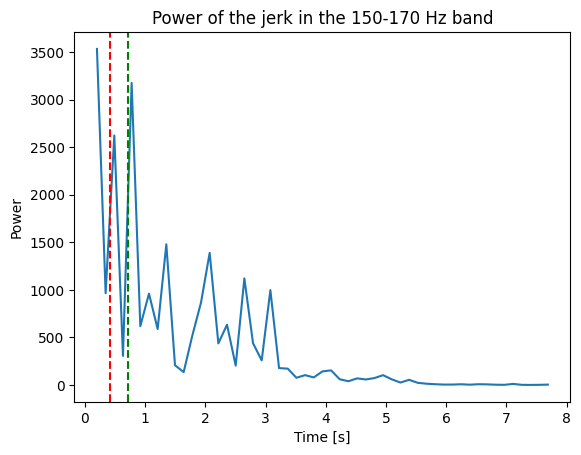

In [ ]:
# Extract the power of the frequencies between 150 and 170 Hz:

band_indices = np.where((f >= 150) & (f <= 170))[0]
band_power = np.sum(Sxx[band_indices, :], axis=0)

plt.plot(t, band_power)
plt.title("Power of the jerk in the 150-170 Hz band")
plt.xlabel("Time [s]")
# plt.axvline(x=extend_time_from_coast_beginning, color="red", linestyle="--", label="Extend command")
plt.axvline(x=subtracted_time_from_coast_beginning, color="red", linestyle="--", label="Extend command")
# 0.3 seconds is SERVO_DELAY
# plt.axvline(x=extend_time_from_coast_beginning + 0.3, color="green", linestyle="--", label="Max no buzz command")
plt.axvline(x=subtracted_time_from_coast_beginning + 0.3, color="green", linestyle="--", label="Max no buzz command")
plt.ylabel("Power")
plt.show()


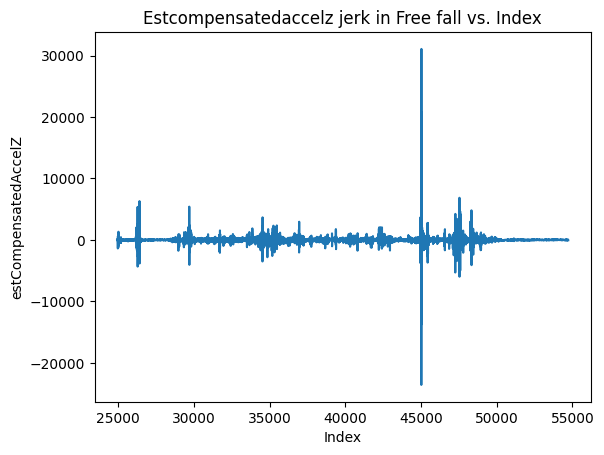

In [333]:
# Now do the same for free fall state, we will find the jerk and the fft of the jerk:

# Get data for the motor burn state:
free_fall_state = data[data['state'] == "F"].copy()
# Only use till row 100000:
free_fall_state = free_fall_state.iloc[80:10000]

# Calculate the jerk:
free_fall_state['jerk'] = np.gradient(free_fall_state[field], 1/500)

# Plot the jerk:
plt.plot(free_fall_state.index, free_fall_state['jerk'])
plt.title(f"{field.capitalize()} {'jerk' if 'jerk' in data.columns else ''} in Free fall vs. Index")
plt.xlabel('Index')
plt.ylabel(field)
plt.show()


The peaks are at frequencies: [114.41532258 115.625      116.17943548 117.13709677 117.28830645
 117.84274194 117.94354839 118.34677419 118.49798387 118.64919355
 119.30443548 119.45564516 119.75806452 119.85887097 120.3125
 120.41330645 121.77419355 121.875      122.02620968 122.12701613
 122.47983871 122.58064516 122.73185484 123.13508065 123.2358871
 123.84072581 123.94153226 124.39516129 124.49596774 124.89919355
 125.05040323 125.2016129  125.60483871 125.70564516 125.85685484
 126.15927419 126.26008065 126.5625     126.66330645 126.7641129
 127.21774194 127.36895161 127.52016129 127.72177419 127.97379032
 128.42741935 128.52822581 128.67943548 128.98185484 129.08266129
 129.23387097 129.38508065 129.53629032 129.6875     129.78830645
 130.19153226 130.29233871 130.44354839 130.59475806 130.74596774
 130.84677419 131.25       131.4516129  131.55241935 131.65322581
 131.95564516 132.10685484 132.51008065 132.6108871  132.71169355
 133.0141129  133.11491935 133.26612903 133.41733871

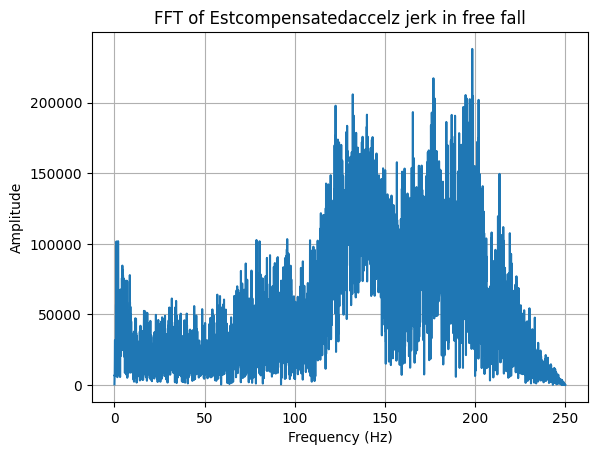

In [334]:
# Calculate the fft of the jerk:

fft_free_fall = np.fft.fft(free_fall_state['jerk'])
T = 1/500
N = len(free_fall_state['jerk'])
fft_free_fall_abs_nyquist = np.abs(fft_free_fall)[:N//2]
fft_freq_free_fall_nyquist = np.fft.fftfreq(N, T)[:N//2]

free_fall_peaks, _ = find_peaks(fft_free_fall_abs_nyquist, height=0.5*np.max(fft_free_fall_abs_nyquist))
print(f"The peaks are at frequencies: {fft_freq_free_fall_nyquist[free_fall_peaks]}")

# Plot the one-sided fft:
plt.plot(fft_freq_free_fall_nyquist, fft_free_fall_abs_nyquist)

# plt.scatter(
#     fft_freq_free_fall_nyquist[free_fall_peaks],
#     fft_free_fall_abs_nyquist[free_fall_peaks],
#     color='red',
#     label='peaks',
#     zorder=5
# )

plt.title(f"FFT of {field.capitalize()} {'jerk' if 'jerk' in data.columns else ''} in free fall")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()

# for peak_idx in free_fall_peaks:
#     # Put text next to the peak and shift it a bit to the right
#     freq = fft_freq_free_fall_nyquist[peak_idx]
#     plt.text(freq, fft_free_fall_abs_nyquist[peak_idx], f"{freq:.1f} Hz", fontsize=8, ha='right')

plt.show()


In [ ]:
# Plot the spectrogram of the jerk in the free fall state:

f, t, Sxx = spectrogram(free_fall_state['jerk'], fs=500, nperseg=256, noverlap=0, nfft=1028, window="blackman",)

Fourier Analysis of Flight 2:

/tmp/ipykernel_44756/272014404.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['jerk'] = np.gradient(data[field],0.002)


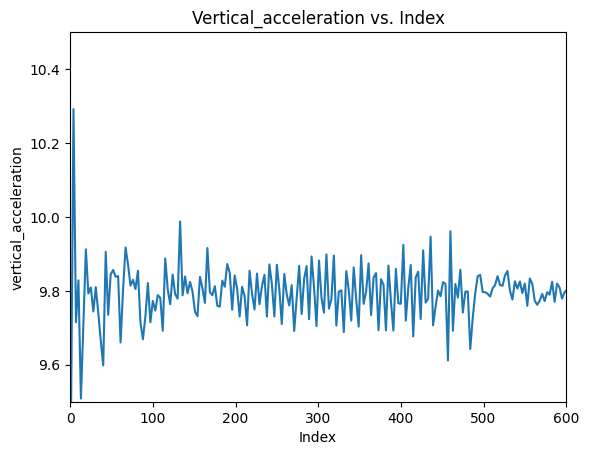

In [112]:
# Calculate and plot the vertical_accel, for flight 2, in standby state

# Remove empty values:
field = 'vertical_acceleration'
data = data_2.dropna(subset=[field])

# Calculate the jerk:
data['jerk'] = np.gradient(data[field],0.002)
# print(data['jerk'])

# Plot the jerk:
# plt.plot(data.index, data['jerk'])
# plt.ylim(-750, 750)  # For compensated_accelerationZ jerk
# print(data['estLinearAccelX'])
plt.plot(data.index, data[field])
plt.ylim(9.5, 10.5)  # For vertical_acceleration
# plt.ylim(-11, -9)  # For linear_accelerationX
# plt.ylim(-2, 2)  # For linear_accelerationY
# plt.ylim(-2, 2)  # For linear_accelerationZ

plt.xlim(0, 600)
plt.title(field.capitalize() + ' vs. Index')
plt.xlabel('Index')
plt.ylabel(field)
plt.show()

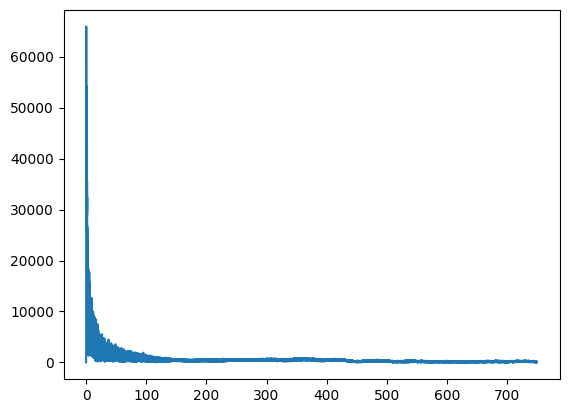

In [13]:
# Find the fft and fftfreq of the vertical_acceleration, for flight 2, in standby state:

# Remove empty values:
field = 'vertical_acceleration'
data = data_2.dropna(subset=[field])
vertical_acceleration_centered = data[field] - np.mean(data[field])

# Calculate the fft, for rows 0 to 600:
data = data.iloc[0:500]
# print(data[field])
fft = np.fft.fft(vertical_acceleration_centered)
freq = np.fft.fftfreq(len(vertical_acceleration_centered), d=1/1500)
magnitude = np.abs(fft)
plt.plot(freq[:len(freq) // 2], magnitude[:len(magnitude) // 2])

1        421.782265
4         66.748375
7       -115.785077
10       -51.636540
13       -30.469957
            ...    
86210     -6.466693
86213     -1.466395
86216      8.153225
86219      7.837358
86222     -6.557445
Name: jerk, Length: 28735, dtype: float64


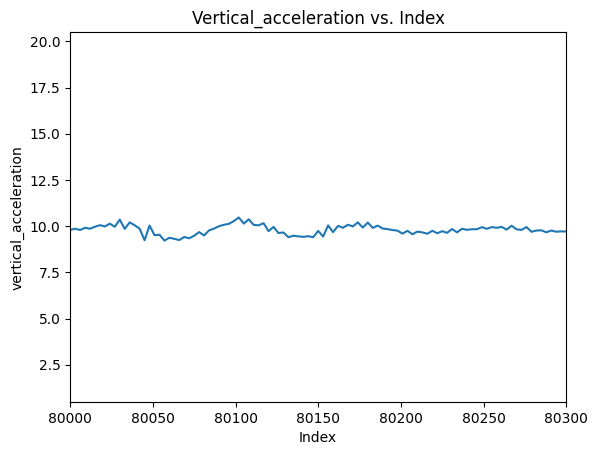

In [ ]:
# Calculate and plot the jerk with the index as x-axis for landed state, only valid for flight 1:

# Remove empty values:
field = 'vertical_acceleration'
data = data.dropna(subset=[field])

# Calculate the jerk:
data['jerk'] = np.gradient(data[field],0.002)
print(data['jerk'])

# Plot the jerk:
# plt.plot(data.index, data['jerk'])
# plt.ylim(-750, 750)  # For compensated_accelerationZ jerk
# print(data['estLinearAccelX'])
plt.plot(data.index, data[field])
plt.ylim(0.5, 20.5)  # For vertical_acceleration
# plt.ylim(-11, -9)  # For linear_accelerationX
# plt.ylim(-2, 2)  # For linear_accelerationY
# plt.ylim(-2, 2)  # For linear_accelerationZ

data_cutoff = 76000
plt.xlim(80000, 80300)
plt.title(field.capitalize() + ' vs. Index')
plt.xlabel('Index')
plt.ylabel(field)
plt.show()

In [28]:
def cutoff_data_at_row_and_save_csv(data: pd.DataFrame, row: int, file_name: str):
    data[:row].to_csv(file_name, index=False)

cutoff_data_at_row_and_save_csv(data, data_cutoff, "genesis_launch_1.csv")